# 0. Install and Import Dependencies

In [1]:
!pip list

Package                                       Version
--------------------------------------------- --------------------
absl-py                                       1.4.0
adal                                          1.2.7
alabaster                                     0.7.12
anaconda-client                               1.9.0
anaconda-navigator                            2.1.1
anaconda-project                              0.10.1
anyio                                         2.2.0
appdirs                                       1.4.4
applaunchservices                             0.2.1
appnope                                       0.1.2
appscript                                     1.1.2
argh                                          0.26.2
argon2-cffi                                   20.1.0
arrow                                         1.2.2
asgiref                                       3.5.2
asn1crypto                                    1.4.0
astroid                                    

jupyter-core                                  4.8.1
jupyter-server                                1.4.1
jupyterlab                                    3.2.1
jupyterlab-pygments                           0.1.2
jupyterlab-server                             2.8.2
jupyterlab-widgets                            1.0.0
keras                                         2.11.0
keyring                                       23.1.0
kiwisolver                                    1.3.1
langcodes                                     3.3.0
lazy-object-proxy                             1.6.0
libarchive-c                                  2.9
libclang                                      15.0.6.1
llvmlite                                      0.37.0
locket                                        0.2.1
lxml                                          4.9.1
Markdown                                      3.4.1
MarkupSafe                                    1.1.1
matplotlib                                    3.4.3
matplotl

In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [9]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [10]:
tf.config.list_physical_devices('GPU')

[]

In [11]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [12]:
import gdown

In [13]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /Users/pidoxy/LipNet/data.zip
  1%|▍                                      | 5.24M/423M [00:03<04:32, 1.54MB/s]

KeyboardInterrupt: 

In [14]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [15]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [16]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


2023-03-15 09:05:34.293764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [18]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [19]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [20]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [21]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
#     file_name = path.split('\\')[-1].split('.')[0]
#     video_path = os.path.join(f'{file_name}.mpg')
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
#     alignment_path = os.path.join(f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [30]:
test_path = './data/s1/bbal6n.mpg'

In [31]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [32]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

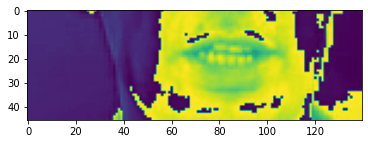

In [33]:
plt.imshow(frames[40])

In [34]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [35]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [36]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [37]:
from matplotlib import pyplot as plt

In [38]:
data = tf.data.Dataset.list_files('data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [39]:
len(test)

50

In [40]:
frames, alignments = data.as_numpy_iterator().next()

In [41]:
len(frames)

2

In [42]:
sample = data.as_numpy_iterator()

In [43]:
val = sample.next(); val[0]

array([[[[[1.3311343 ],
          [1.3311343 ],
          [1.3311343 ],
          ...,
          [9.432037  ],
          [0.03803241],
          [0.11409722]],

         [[1.3311343 ],
          [1.3311343 ],
          [1.3311343 ],
          ...,
          [9.432037  ],
          [0.        ],
          [0.03803241]],

         [[1.2931019 ],
          [1.2931019 ],
          [1.2931019 ],
          ...,
          [0.11409722],
          [0.15212964],
          [0.15212964]],

         ...,

         [[0.9888426 ],
          [0.9888426 ],
          [0.9508102 ],
          ...,
          [9.508102  ],
          [9.698264  ],
          [0.03803241]],

         [[0.9888426 ],
          [0.9888426 ],
          [0.9508102 ],
          ...,
          [9.355972  ],
          [9.508102  ],
          [9.660232  ]],

         [[0.9888426 ],
          [0.9888426 ],
          [0.9508102 ],
          ...,
          [9.47007   ],
          [9.47007   ],
          [9.546134  ]]],


        [[[1.3691

In [44]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.698264122009277]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.698264122009277]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.698264122009277]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.698264122009277]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.698264122009277]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.698264122009277]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.698264122009277]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

Lossy conversion from float32 to uint8. Range [0.0, 9.698264122009277]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.698264122009277]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.698264122009277]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.698264122009277]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.698264122009277]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.698264122009277]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.698264122009277]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

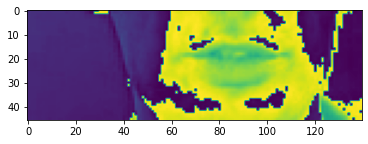

In [45]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [46]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay white by s two please'>

# 3. Design the Deep Neural Network

In [89]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [90]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [91]:
# define deep neural network

model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [92]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_6 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_7 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [93]:
5*17*75

6375

In [94]:
yhat = model.predict(val[0])

1/1 [==============================] - 7s 7s/step


In [95]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnssssssssss  nn9999sssssssssssss'>

In [96]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnssssssssss  nn9999sssssssssssss'>

In [97]:
model.input_shape

(None, 75, 46, 140, 1)

In [98]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [99]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [100]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [101]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [102]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [103]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [104]:
schedule_callback = LearningRateScheduler(scheduler)

In [105]:
example_callback = ProduceExample(data)

In [64]:
# model.fit(data, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
181/450 [===========>..................] - ETA: 3:38:58 - loss: 96.8940

[mpeg1video @ 0x7fd0b9e86400] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd0b9e86400] Warning MVs not available


338/450 [=====================>........] - ETA: 1:45:46 - loss: 87.7973

KeyboardInterrupt: 

# 5. Make a Prediction 

In [67]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /Users/pidoxy/LipNet/checkpoints.zip
100%|██████████████████████████████████████| 94.5M/94.5M [00:45<00:00, 2.08MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [106]:
model.load_weights('models/checkpoint')

In [107]:
test_data = test.as_numpy_iterator()

In [108]:
sample = test_data.next()

[mpeg1video @ 0x7fd04d158000] ac-tex damaged at 22 17
[mpeg1video @ 0x7fd04d158000] Warning MVs not available


In [113]:
yhat = model.predict(sample[0])

1/1 [==============================] - 3s 3s/step


In [114]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green in f two please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay white by z six please'>]

In [115]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [112]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green in f two please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay white by z six please'>]

# Test on a Video

In [116]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [117]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [118]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 2s 2s/step


In [119]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [120]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]